In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%cd /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/
%cd gfdl.ncrc4-intel16-prod/pp/ocean_monthly
fs=xr.open_dataset('ocean_monthly.static.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
#print(fs)
%cd av/monthly_5yr/

/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_monthly
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_monthly/av/monthly_5yr


In [72]:
yearly = xr.open_mfdataset(['ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc','ocean_monthly.2003-2007.03.nc',\
                           'ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc','ocean_monthly.2003-2007.06.nc',\
                           'ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc','ocean_monthly.2003-2007.09.nc',\
                           'ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc','ocean_monthly.2003-2007.12.nc'])

spring = xr.open_mfdataset(['ocean_monthly.2003-2007.03.nc','ocean_monthly.2003-2007.04.nc','ocean_monthly.2003-2007.05.nc'])
summer = xr.open_mfdataset(['ocean_monthly.2003-2007.06.nc','ocean_monthly.2003-2007.07.nc','ocean_monthly.2003-2007.08.nc'])
fall   = xr.open_mfdataset(['ocean_monthly.2003-2007.09.nc','ocean_monthly.2003-2007.10.nc','ocean_monthly.2003-2007.11.nc'])
winter = xr.open_mfdataset(['ocean_monthly.2003-2007.12.nc','ocean_monthly.2003-2007.01.nc','ocean_monthly.2003-2007.02.nc'])

fhist  = yearly;
Pressure  = fhist.variables['pso'][:,:,:] #Sea Water Pressure at Sea Water Surface Pa
SST       = fhist.variables['tos'][:,:,:] #tos:long_name = "Sea Surface Temperature" degC
SSS_PSU   = fhist.variables['sos'][:,:,:] #sos:long_name = "Sea Surface Salinity" psu

# Mass flux
mass_in   = fhist.variables['net_massin'][:,:,:]  #all positive
mass_out  = fhist.variables['net_massout'][:,:,:] #all negative
pme_river = mass_in + mass_out #Net Mass flux in kg m-2 s-1, in is positive.
salt_flux_psu = fhist.variables['sfdsi'][:,:,:]*1000.0  #positive salt flux into ocean kg/m2s, ...
restoring_salt_flux_psu = fhist.variables['salt_flux_added'][:,:,:]*1000.0  #positive salt flux into ocean kg/m2s, ...
#...needs to multiplied by 1000 to convert to psu for consistency with beta


In [73]:
SSS = SA_from_SP(SSS_PSU,Pressure,lon,lat) #absolute salinity g/kg
pot_rho_1 = sigma1(SSS, SST) #potential density referenced to 1000dbar
haline_contraction = beta(SSS, SST, Pressure) #kg/g
#From freshwater fluxes:
salt_transformation_fresh = -haline_contraction*SSS*pme_river #*31.0 #last integer is days per month
#From salt fluxes:
salt_transformation_salt  = -haline_contraction*salt_flux_psu
salt_transformation_restoring_salt = -haline_contraction*restoring_salt_flux_psu
#Net:
salt_transformation = salt_transformation_salt + salt_transformation_fresh 



In [74]:
print('done')
print(np.nanmean(salt_transformation_salt))

done
8.991855146671481e-09


In [75]:
#Restoring fluxes
vprec     = fhist.variables['vprec'][:,:,:]  #"Virtual liquid precip into ocean due to SSS restoring (or regulating water level)" "kg m-2 s-1" 
salt_flux_added = fhist.variables['salt_flux_added'][:,:,:] #"Salt flux into ocean at surface due to restoring or flux adjustment" "kg m-2 s-1"
sfdsi = fhist.variables['sfdsi'][:,:,:] #"Downward Sea Ice Basal Salt Flux" "kg m-2 s-1"
#SFDSI INCLUDES SALT_FLUX_ADDED. Just look at sfdsi! 

prlq  = fhist.variables['prlq'][:,:,:]  #"Rainfall Flux where Ice Free Ocean over Sea" "kg m-2 s-1" 
prsn  = fhist.variables['prsn'][:,:,:]  #"Snowfall Flux where Ice Free Ocean over Sea" "kg m-2 s-1"
evs   = fhist.variables['evs'][:,:,:]   #"Water Evaporation Flux Where Ice Free Ocean over Sea" "kg m-2 s-1"
friver= fhist.variables['friver'][:,:,:] #Water Flux into Sea Water From Rivers "kg m-2 s-1" 
ficeberg=fhist.variables['ficeberg'][:,:,:] #Water Flux into Seawater from Icebergs "kg m-2 s-1"
wfo   = fhist.variables['wfo'][:,:,:]   #Water Flux Into Sea Water "kg m-2 s-1" 

salt_forcing_test1 = -haline_contraction*SSS*wfo
salt_forcing_test2 = -haline_contraction*SSS*(wfo-ficeberg-friver-evs-prsn-prlq-vprec)
salt_forcing_test3 = -haline_contraction*SSS*(mass_in+mass_out)
precip_forcing     = -haline_contraction*SSS*prlq
evap_forcing       = -haline_contraction*SSS*evs
print('done')
#salt_forcing_test1 and salt_forcing_test3 are ~equal, and salt_forcing_test2 is near zero GREAT - THIS MEANS WATER FLUXES BALANCE AS I EXPECT
#So basically mass_in+mass out is comprised of iceberg, river, evs, prsn, prlq, vprec
#The net salt flux in is given by sfdsi (salt flux due to ice formation + the restoring (salt_flux_added))


done


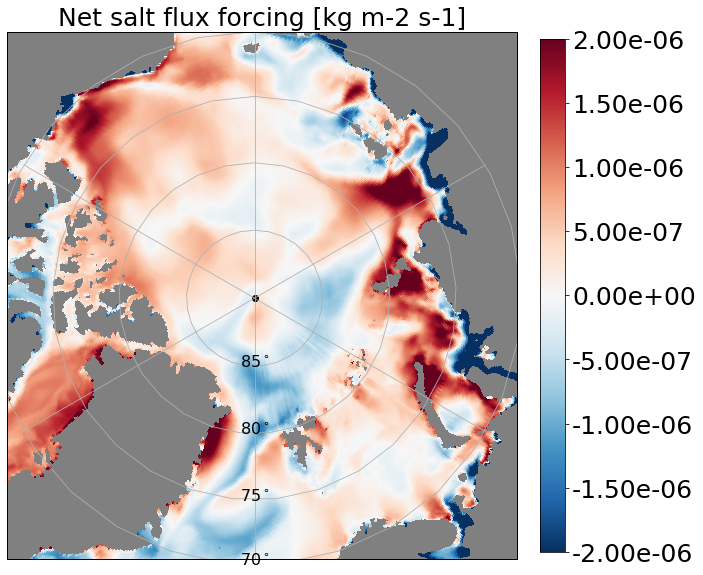

In [76]:
#The net salt flux salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(salt_transformation_salt,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Net salt flux forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

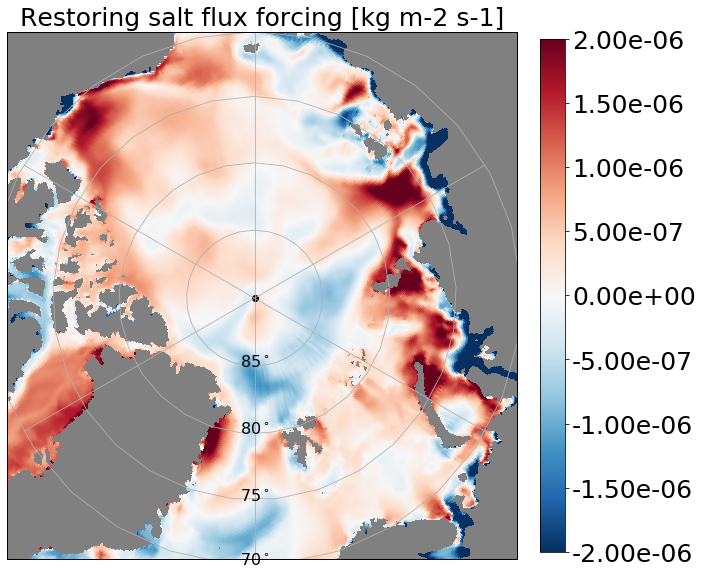

In [77]:
#The restoring salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(salt_transformation_restoring_salt,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Restoring salt flux forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

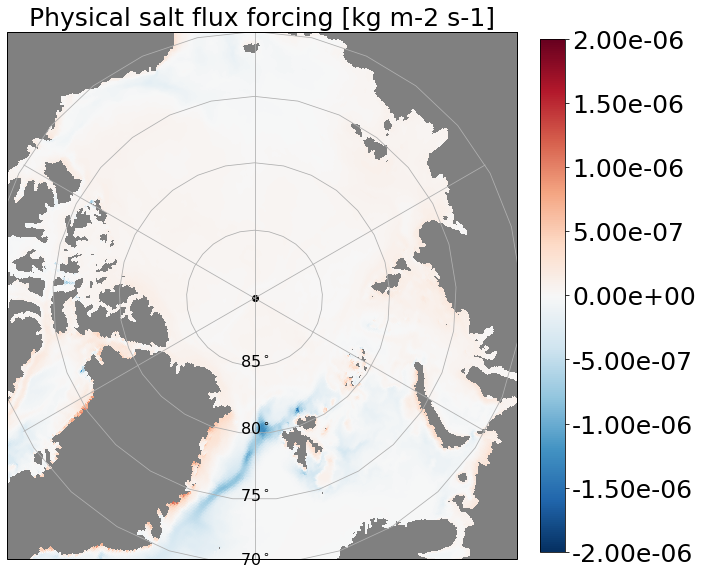

In [78]:
#The physical (net-restoring) salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(salt_transformation_salt-salt_transformation_restoring_salt,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Physical salt flux forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

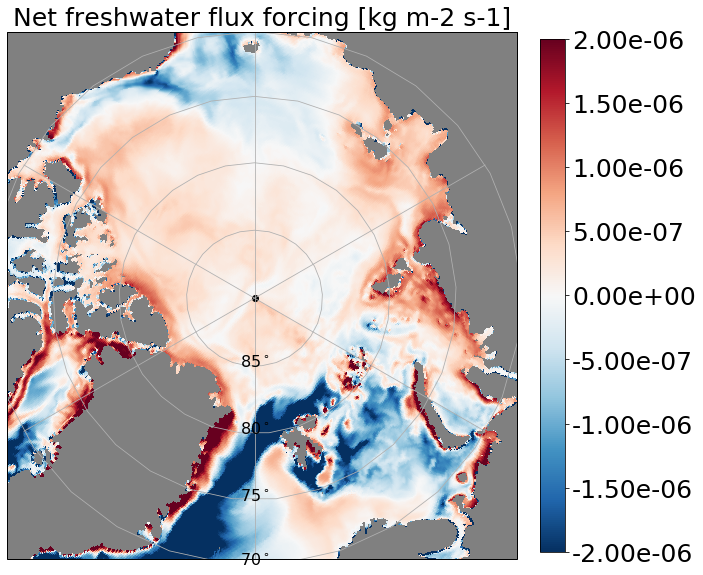

In [79]:
#The net freshwater salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(salt_transformation_fresh,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Net freshwater flux forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

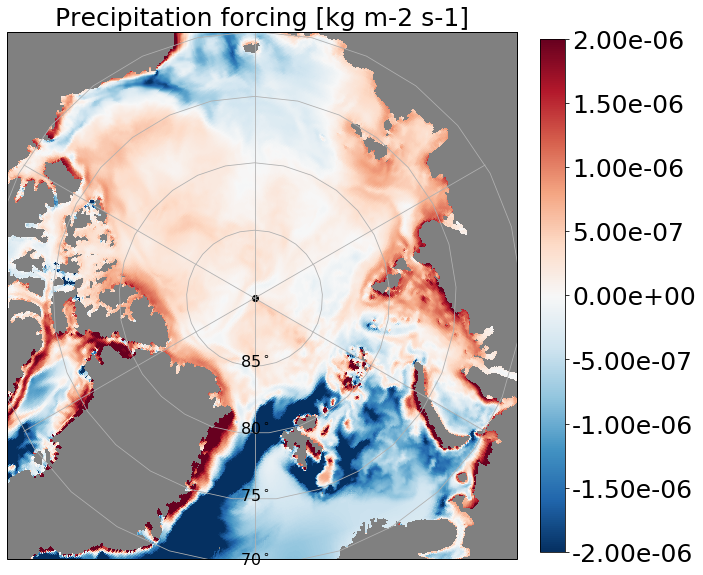

In [80]:
#The precip freshwater salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(precip_forcing,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Precipitation forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')

In [ ]:
#The evap freshwater salinity forcing
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(0, 90))
ax.set_extent([-180, 180, 70, 90],ccrs.PlateCarree())

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=2);

plt.pcolormesh(lon, lat,np.nanmean(evap_forcing,axis=0),transform=ccrs.PlateCarree(),vmin=-2e-6,vmax=2e-6,cmap='RdBu_r');


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.2e'); cbar.ax.tick_params(labelsize=25);
gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Evaporation forcing [kg m-2 s-1]',fontsize=25)
gl.ylocator = mticker.FixedLocator([70, 75, 80, 85, 90])

ax.scatter(180, 90, marker='o',c='black', transform=ccrs.PlateCarree())
pointx=[0,0,0,0]; pointy=[70,75,80,85]; text=['70$^\circ$','75$^\circ$','80$^\circ$','85$^\circ$']
for i in range(len(pointx)):
    ax.text(pointx[i],pointy[i],text[i],ha='center', transform=ccrs.PlateCarree(),fontsize=16,color='black')